# classification es el notebook oficial de clasificación

### - Limpiamos los datos según conclusiones del notebook main
### - Probaremos distintos algorítmos de clasificación y compararemos los resultados
### - Utilizamos el dataset de train ya recortado por la cátedra (igual creamos un test para pruebas internas)

## A probar: LOGISTIC REGRESSION - SVM - DESICION TREE

---





## ACA TODOS LOS IMPORTS DEL NOTEBOOK

In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, AdaBoostRegressor, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, auc, roc_auc_score, roc_curve, RocCurveDisplay, PrecisionRecallDisplay, plot_precision_recall_curve, plot_roc_curve 

## LECTURA Y LIMPIEZA DEL DATASET

In [21]:
df_orig = pd.read_csv(r"DS_G3_HeartFailure_FULL_train.csv",index_col=0)

## Transformaciones necesarias al df

In [22]:
#df_orig["cant_path"] = df_orig["anaemia"]+df_orig["high_blood_pressure"]+df_orig["diabetes"]
#df_cleaned = df_orig.copy()
#df_cleaned = df_orig.drop(["time","anaemia","diabetes","high_blood_pressure","sex","smoking"],axis=1)
df_cleaned = df_orig.drop(["anaemia","diabetes","high_blood_pressure","sex","smoking"],axis=1)
#df_cleaned = df_orig.drop(["time","anaemia","diabetes","high_blood_pressure","sex","smoking","creatinine_phosphokinase","platelets"],axis=1)
# NOS QUEDAMOS CON AGE, EJECTION_FRACTION, SERUM_CREATININE, SERUM_SODIUM Y DEATH_EVENT


In [6]:
df_cleaned.head()

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time,DEATH_EVENT
55,95.0,371,30,461000.0,2.0,132,50,1
180,40.0,478,30,303000.0,0.9,136,148,0
237,70.0,232,30,173000.0,1.2,132,210,0
280,70.0,2695,40,241000.0,1.0,137,247,0
181,59.0,176,25,221000.0,1.0,136,150,1


In [23]:
feat_train, feat_test, targ_train, targ_test = train_test_split(df_cleaned.drop(["DEATH_EVENT"],axis=1),df_cleaned["DEATH_EVENT"],test_size=0.2)
#HAY QUE SEPARAR EL TEST ANTES DE ESTANDARIZAR PARA QUE NO INFLUYAN LOS FEATURES DE TEST EN LA MEDIA Y VARIANZA

In [ ]:
#APLICAMOS SMOTE PARA AUMENTAR LA CANTIDAD DE SAMPLES Y BALANCEAR EL TARGET
feat_train, targ_train = SMOTE().fit_resample(feat_train, targ_train)

In [10]:
#NO ES NECESARIO EN CIERTOS ALGORITMOS VER
scaler = StandardScaler()
feat_train = scaler.fit_transform(feat_train)
t_var = scaler.var_ # ESTA VARIANZA HAY Q USAR PARA STANDARIZAR EL TARG_TEST
t_mean = scaler.mean_ # ESTA MEDIA HAY Q USAR PARA STANDARIZAR EL TARG_TEST

## ACA TENEMOS EL DATASET RECORTADO Y STANDARIZADO 

In [85]:
sss = StratifiedShuffleSplit() # USAMOS ESTO PARA CV POR EL DESBALANCE

---
---
---

# LOGISTIC REGRESSION

### La teoría indica que el Logistic Regressor no tiene hyperparametros q valgan la pena tunear mas allá del penalty o un poco el "C".

In [113]:
hyperparam = {"poly__degree":[n for n in range(1,3)],"regressor__C":[n for n in np.logspace(-20,2, num=40)]}
lr_model = Pipeline([["poly",PolynomialFeatures()],["regressor",LogisticRegression(fit_intercept=False, max_iter=20000)]])
lr_grilla = GridSearchCV(lr_model,hyperparam,cv=sss,scoring="f1",n_jobs=-1)
lr_grilla.fit(feat_train,targ_train)
lr_model = lr_grilla.best_estimator_
lr_model.predict_proba(feat_train)[1,:]
print(lr_grilla.best_params_)
print("Grilla Best Score: {:.3f}".format(lr_grilla.best_score_))
lr_scoring = cross_val_score(lr_model, feat_train, targ_train,cv=sss, scoring="f1")
print("Cross Validation Score: {:.3f} +/- {:.3f}".format(lr_scoring.mean(),lr_scoring.std()))

{'poly__degree': 1, 'regressor__C': 0.04124626382901365}
Grilla Best Score: 0.725
Cross Validation Score: 0.732 +/- 0.131


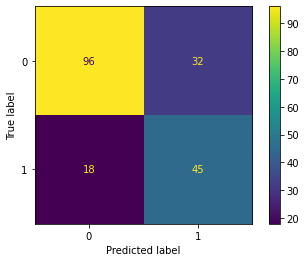

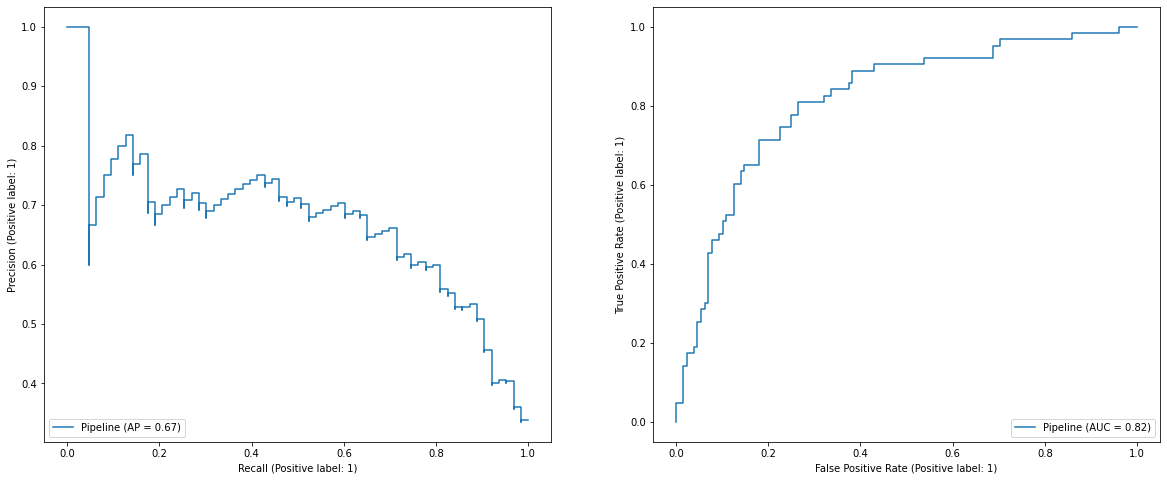

In [17]:
lr_predicted = cross_val_predict(lr_model,feat_train,targ_train,cv=40)
cm = confusion_matrix(targ_train, lr_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
plot_precision_recall_curve(lr_model, feat_train, targ_train,ax=ax1)
plot_roc_curve(lr_model, feat_train, targ_train,ax=ax2)

---

# SUPPORT VECTOR MACHINES

In [18]:
hyperparam = {"poly__degree":[n for n in range(1,3)],"SVC__C":[n for n in np.logspace(-80,-15, num=25)]}
svml_model = Pipeline([["poly",PolynomialFeatures()],["SVC",LinearSVC(loss='hinge', class_weight="balanced", fit_intercept=False, max_iter=20000)]])
svml_grilla = GridSearchCV(svml_model,hyperparam,cv=sss,scoring="f1",n_jobs=-1)
svml_grilla.fit(feat_train,targ_train)
print(svml_grilla.best_params_)
svml_model = svml_grilla.best_estimator_
print("Grilla Best Score: {:.2f}".format(svml_grilla.best_score_))
svml_scoring = cross_val_score(svml_model, feat_train, targ_train,cv=sss, scoring="f1")
print("Cross Validation Score: {:.2f} +/- {:.2f}".format(svml_scoring.mean(),svml_scoring.std()))

{'SVC__C': 1e-80, 'poly__degree': 1}
Grilla Best Score: 0.66
Cross Validation Score: 0.67 +/- 0.11


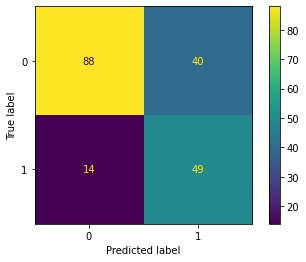

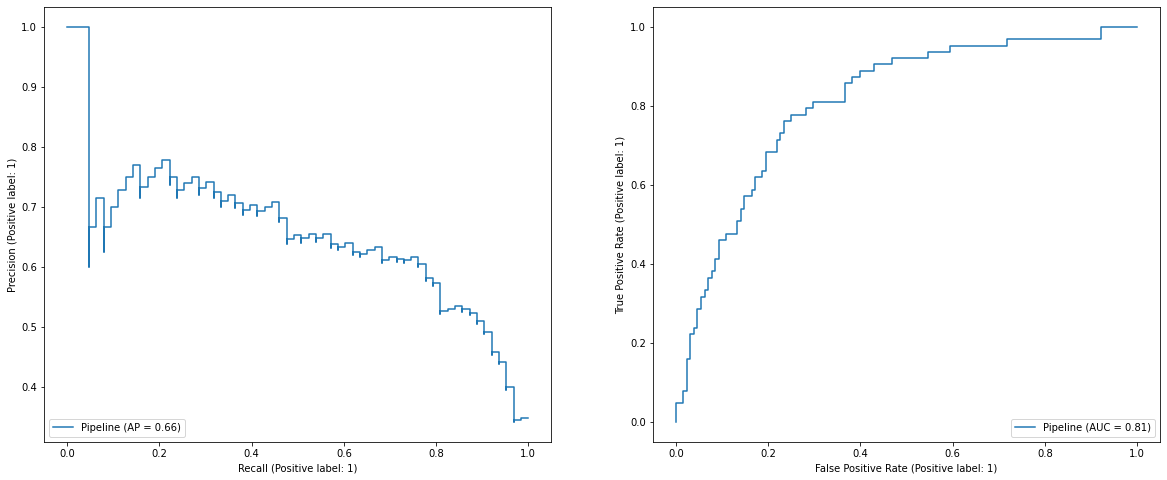

In [19]:
svml_predicted = cross_val_predict(svml_model,feat_train,targ_train,cv=40)
cm = confusion_matrix(targ_train, svml_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
plot_precision_recall_curve(svml_model, feat_train, targ_train,ax=ax1)
plot_roc_curve(svml_model, feat_train, targ_train,ax=ax2)

---

# SVM no lineal

In [22]:
hyperparam = {"SVC__kernel":["rbf","poly","sigmoid"],"SVC__C":[n for n in np.logspace(-1,1, num=25)],"SVC__gamma":[n for n in np.logspace(-2,0, num=25)]}
svm_model = Pipeline([["SVC",SVC(class_weight="balanced")]])
svm_grilla = GridSearchCV(svm_model,hyperparam,cv=sss,scoring="f1",n_jobs=-1)
svm_grilla.fit(feat_train,targ_train)
print(svm_grilla.best_params_)
svm_model = svm_grilla.best_estimator_
print("Grilla Best Score: {:.3f}".format(svm_grilla.best_score_))
svm_scoring = cross_val_score(svm_model, feat_train, targ_train,cv=sss, scoring="f1")
print("Cross Validation Score: {:.3f} +/- {:.3f}".format(svm_scoring.mean(),svm_scoring.std()))

{'SVC__C': 1.2115276586285881, 'SVC__gamma': 0.06812920690579612, 'SVC__kernel': 'rbf'}
Grilla Best Score: 0.688
Cross Validation Score: 0.617 +/- 0.093


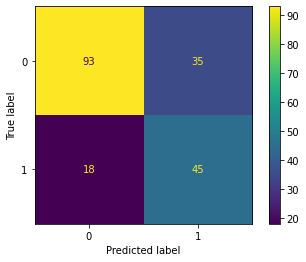

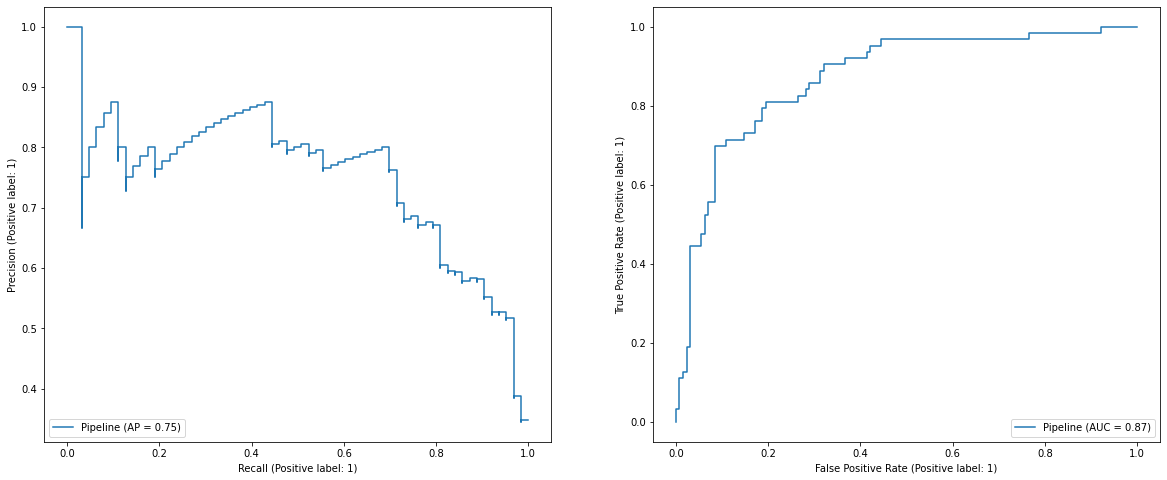

In [23]:
svm_predicted = cross_val_predict(svm_model,feat_train,targ_train,cv=40)
cm = confusion_matrix(targ_train, svm_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
plot_precision_recall_curve(svm_model, feat_train, targ_train,ax=ax1)
plot_roc_curve(svm_model, feat_train, targ_train,ax=ax2)

---

# DECISION TREE

max_depth: por defecto es None, controla la profundidad del arbol.
min_samples_split: establece el minimo numero de muestras que debe tener un nodo para poder seguir partiendolo.
min_samples_leaf: el minimo numero de muestras que debe tener una hoja (ie nodo final).
min_weight_fraction_leaf: la minima fraccion pesada de muestras que debe poseer una hoja.
max_leaf_nodes: maxima cantidad de hojas.
max_features: maxima cantidad de features evaluados en un splitting.

In [70]:
hyperparam = {"max_depth":[2,3,4,5,10,15,20,25,30],"max_leaf_nodes":[2,3,4,5,6,25,50]}
dt_model = DecisionTreeClassifier(class_weight="balanced")
dt_grilla = GridSearchCV(dt_model,hyperparam,cv=sss,scoring="f1",n_jobs=-1)
dt_grilla.fit(feat_train,targ_train)
print(dt_grilla.best_params_)
dt_model = dt_grilla.best_estimator_
print("Grilla Best Score: {:.3f}".format(dt_grilla.best_score_))
dt_scoring = cross_val_score(dt_model, feat_train, targ_train,cv=sss, scoring="f1")
print("Cross Validation Score: {:.3f} +/- {:.3f}".format(dt_scoring.mean(),dt_scoring.std()))

{'max_depth': 3, 'max_leaf_nodes': 4}
Grilla Best Score: 0.638
Cross Validation Score: 0.663 +/- 0.106


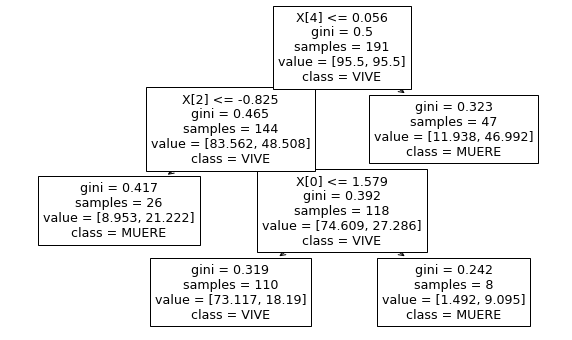

In [71]:
plt.figure(figsize=[10,6])
plot_tree(dt_model,class_names=["VIVE","MUERE"])
plt.show()

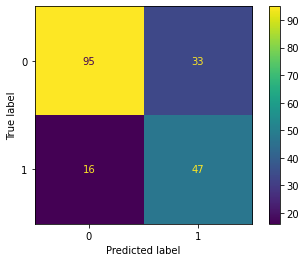

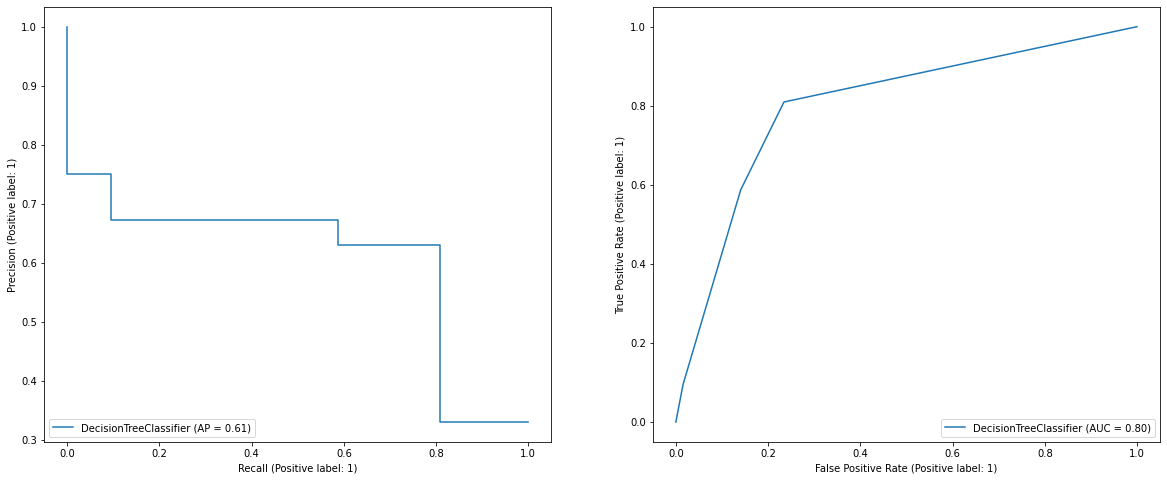

In [72]:
dt_predicted = cross_val_predict(dt_model,feat_train,targ_train,cv=40)
cm = confusion_matrix(targ_train, dt_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
plot_precision_recall_curve(dt_model, feat_train, targ_train,ax=ax1)
plot_roc_curve(dt_model, feat_train, targ_train,ax=ax2)

---

# PERCEPTRON

In [28]:
hyperparam = {"poly__degree":[n for n in range(6,11)],"Perc__alpha":[n for n in np.logspace(-5.0,0, num=25)]}
per_model = Pipeline([["poly",PolynomialFeatures()],["Perc",Perceptron(penalty="l2",max_iter=20000)]])

per_grilla = GridSearchCV(per_model,hyperparam,cv=sss,scoring="f1",n_jobs=-1)

per_grilla.fit(feat_train,targ_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=40, random_state=None, test_size=None,
            train_size=None),
             estimator=Pipeline(steps=[['poly', PolynomialFeatures()],
                                       ['Perc',
                                        Perceptron(max_iter=20000,
                                                   penalty='l2')]]),
             n_jobs=-1,
             param_grid={'Perc__alpha': [1e-05, 1.6155980984398728e-05,
                                         2.6101572156825386e-05,
                                         4.216965034285822e-05,
                                         6.812920690579608e-05,
                                         0.0001100...
                                         0.0007498942093324559,
                                         0.001211527658628589,
                                         0.0019573417814876615,
                                         0.0031622776601683794,
                              

In [29]:
per_model = per_grilla.best_estimator_
print(per_grilla.best_params_)
print("Grilla Best Score: {}".format(per_grilla.best_score_))

print("Cross Validation Score: {}".format(cross_val_score(per_model, feat_train, targ_train,cv=sss,scoring="f1").mean()))

{'Perc__alpha': 0.0019573417814876615, 'poly__degree': 9}
Grilla Best Score: 0.5854538231376466
Cross Validation Score: 0.5522678452438514


In [30]:
per_predicted = cross_val_predict(per_model,feat_train,targ_train,cv=40)

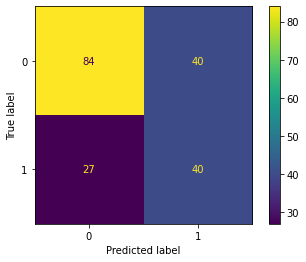

In [31]:
cm = confusion_matrix(targ_train, per_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

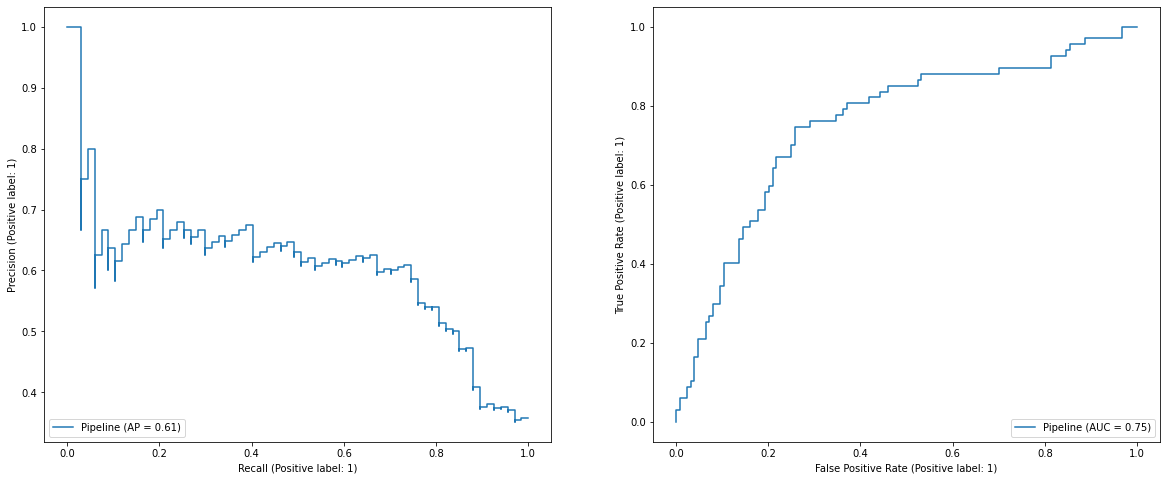

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
plot_precision_recall_curve(per_model, feat_train, targ_train,ax=ax1)
plot_roc_curve(per_model, feat_train, targ_train,ax=ax2)

# NAIVE BAYES

In [42]:
hyperparam = {"poly__degree":[n for n in range(1,3)],}
nb_model = Pipeline([["poly",PolynomialFeatures()],["NB",GaussianNB()]])

nb_grilla = GridSearchCV(nb_model,hyperparam,cv=sss,scoring="f1",n_jobs=-1)

nb_grilla.fit(feat_train,targ_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=40, random_state=None, test_size=None,
            train_size=None),
             estimator=Pipeline(steps=[['poly', PolynomialFeatures()],
                                       ['NB', GaussianNB()]]),
             n_jobs=-1, param_grid={'poly__degree': [1, 2]}, scoring='f1')

In [43]:
nb_model = nb_grilla.best_estimator_
print(nb_grilla.best_params_)
print("Grilla Best Score: {}".format(nb_grilla.best_score_))

print("Cross Validation Score: {}".format(cross_val_score(nb_model, feat_train, targ_train,cv=sss,scoring="f1").mean()))

{'poly__degree': 1}
Grilla Best Score: 0.4078185703185703
Cross Validation Score: 0.422973692973693


In [44]:
nb_predicted = cross_val_predict(nb_model,feat_train,targ_train,cv=40)

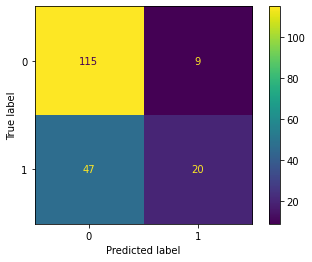

In [45]:
cm = confusion_matrix(targ_train, nb_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

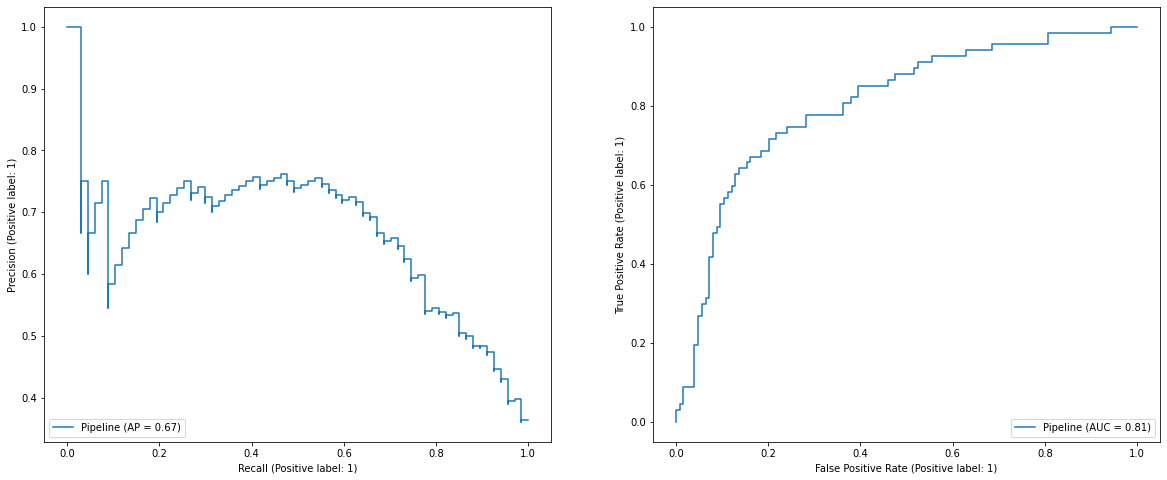

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
plot_precision_recall_curve(nb_model, feat_train, targ_train,ax=ax1)
plot_roc_curve(nb_model, feat_train, targ_train,ax=ax2)

---
---

# RANDOM FOREST

In [78]:
hyperparam = {"n_estimators":[100,200,500],"max_depth":[5],"min_samples_leaf":[2,10]}
rf_model = RandomForestClassifier()
rf_grilla = GridSearchCV(rf_model,hyperparam,cv=10,scoring="f1",n_jobs=-1)
rf_grilla.fit(feat_train,targ_train)
rf_model = rf_grilla.best_estimator_
print(rf_grilla.best_params_)
print("Grilla Best Score: {:.3f}".format(rf_grilla.best_score_))
rf_scoring = cross_val_score(rf_model, feat_train, targ_train,cv=10, scoring="f1")
print("Cross Validation Score: {:.3f} +/- {:.3f}".format(rf_scoring.mean(),rf_scoring.std()))

{'max_depth': 5, 'min_samples_leaf': 2, 'n_estimators': 100}
Grilla Best Score: 0.858
Cross Validation Score: 0.853 +/- 0.088


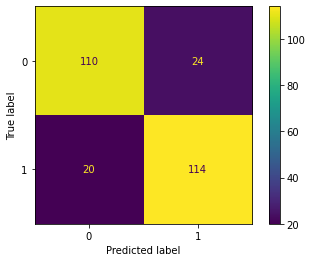

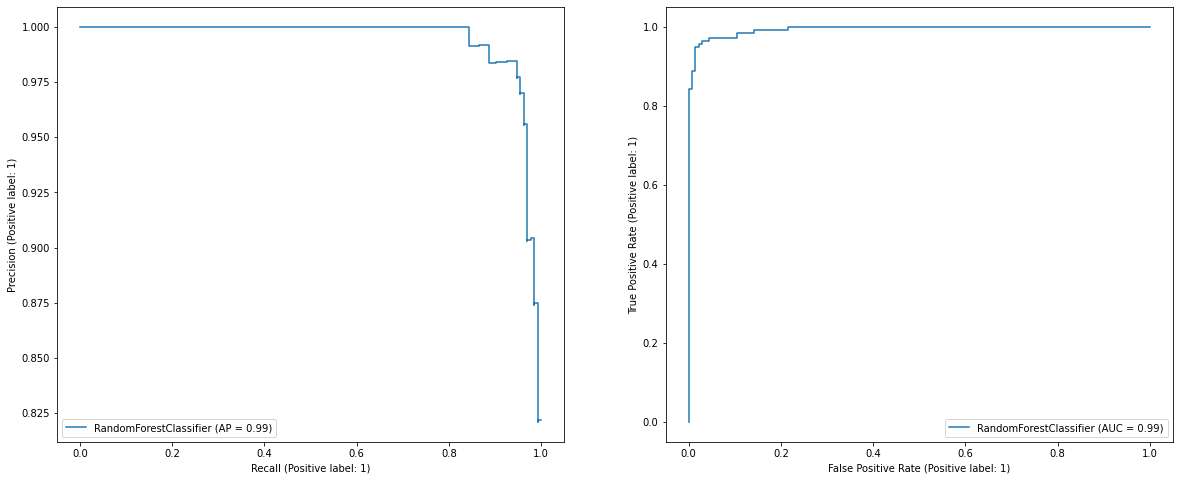

In [80]:
rf_predicted = cross_val_predict(rf_model,feat_train,targ_train,cv=10)
cm = confusion_matrix(targ_train, rf_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
plot_precision_recall_curve(rf_model, feat_train, targ_train,ax=ax1)
plot_roc_curve(rf_model, feat_train, targ_train,ax=ax2)

---


# ADABOOST CLASIFFIER

In [72]:
ada_model = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=6), n_estimators=500,
    algorithm="SAMME", learning_rate=1)
ada_model.fit(feat_train,targ_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=6),
                   learning_rate=1, n_estimators=500)

In [73]:
ada_predicted = cross_val_predict(ada_model,feat_train,targ_train,cv=10)
print(f1_score(targ_train,ada_predicted))

0.891304347826087


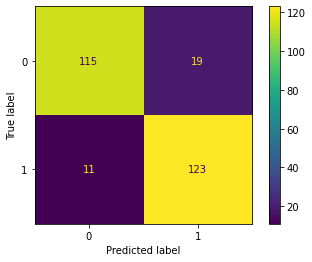

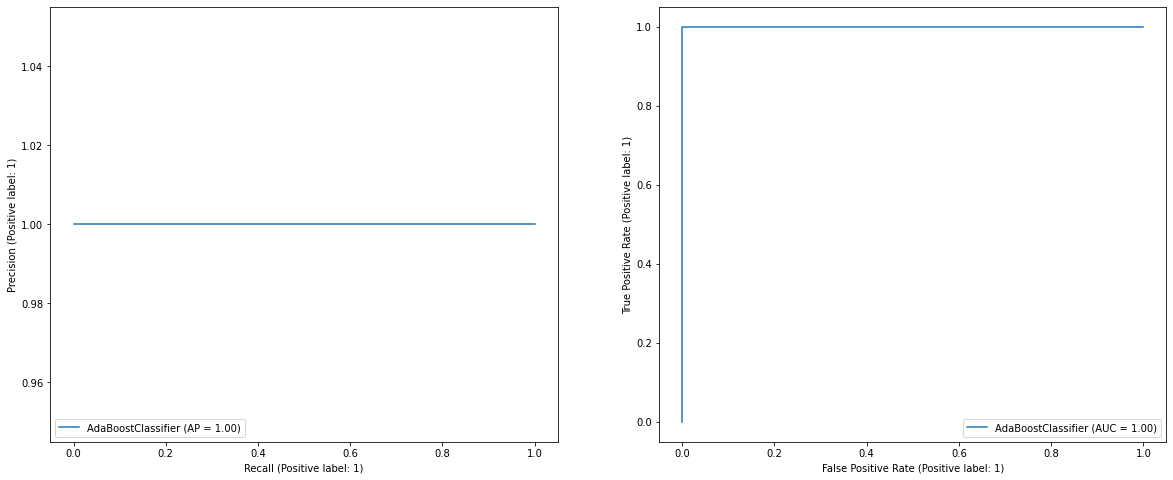

In [81]:
cm = confusion_matrix(targ_train, ada_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
plot_precision_recall_curve(ada_model, feat_train, targ_train,ax=ax1)
plot_roc_curve(ada_model, feat_train, targ_train,ax=ax2)

NameError: name 'lr_model' is not defined

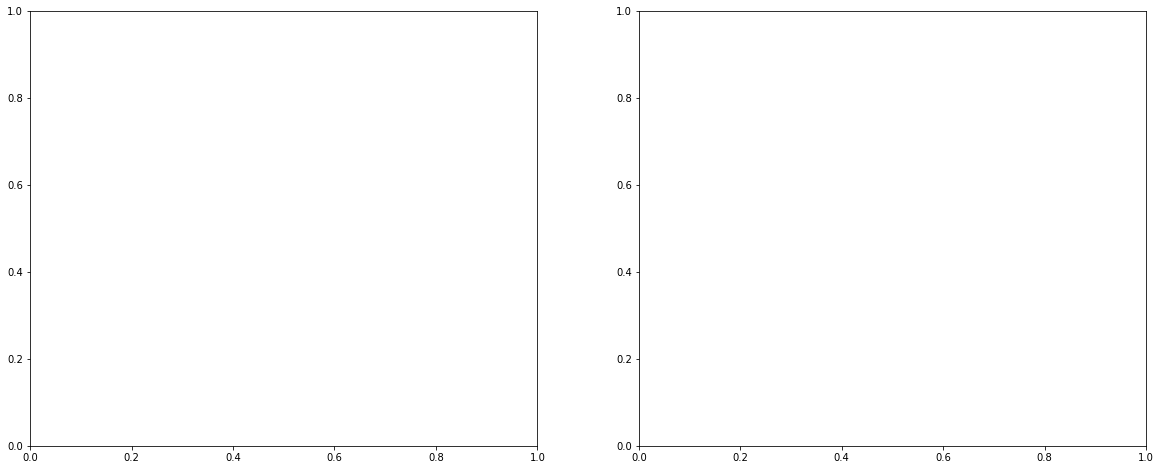

In [33]:
#ESTO ESTÁ MAL PORQ ESTOY VIENDO RESULTADOS DEL GRID Y NO DEL CROSS VALIDATION

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
modelos = ["Perceptron","NBayes","Logistic","SVMLineal","SVM","DTree"]
n=0
for modelo in [per_model,nb_model,lr_model,svml_model,svm_model,dt_model]:
    plot_precision_recall_curve(modelo, feat_train, targ_train,ax=ax1,name=modelos[n])
    plot_roc_curve(modelo, feat_train, targ_train,ax=ax2,name=modelos[n])
    n+=1